In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# LOADS PRE-EXISTING NET

In [2]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

fmnist_class_names = ["T-shirt/top",
"Trouser",
"Pullover",
"Dress",
"Coat",
"Sandal",
"Shirt",
"Sneaker",
"Bag",
"Ankle boot"]

mnist_class_names = ["Zero",
"One",
"Two",
"Three",
"Four",
"Five",
"Six",
"Seven",
"Eight",
"Nine"]

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root="./mnist", train=True, transform=trans, download=True)
test_set2 = dset.MNIST(root="./mnist", train=False, transform=trans, download=True)

batch_size = 32

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

test_loader2 = torch.utils.data.DataLoader(
                dataset=test_set2,
                batch_size=batch_size,
                shuffle=False)

use_cuda = True

epsilons = [0, .05, .1, .15, .2, .25, .3]

criterion = nn.CrossEntropyLoss()

In [3]:
import torch.nn as nn
from collections import OrderedDict
import torch.utils.model_zoo as model_zoo

model_urls = {
    'mnist': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth'
}

class MLP(nn.Module):
    def __init__(self, input_dims, n_hiddens, n_class):
        super(MLP, self).__init__()
        assert isinstance(input_dims, int), 'Please provide int for input_dims'
        self.input_dims = input_dims
        current_dims = input_dims
        layers = OrderedDict()

        if isinstance(n_hiddens, int):
            n_hiddens = [n_hiddens]
        else:
            n_hiddens = list(n_hiddens)
        for i, n_hidden in enumerate(n_hiddens):
            layers['fc{}'.format(i+1)] = nn.Linear(current_dims, n_hidden)
            layers['relu{}'.format(i+1)] = nn.ReLU()
            layers['drop{}'.format(i+1)] = nn.Dropout(0.2)
            current_dims = n_hidden
        layers['out'] = nn.Linear(current_dims, n_class)

        self.model= nn.Sequential(layers)
        print(self.model)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

def mnist(input_dims=784, n_hiddens=[256, 256], n_class=10, pretrained=None):
    model = MLP(input_dims, n_hiddens, n_class)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['mnist'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

if use_cuda:
    model = mnist(pretrained=True).cuda()
    
criterion = nn.CrossEntropyLoss()

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


# TRAINS NEW NET DO NOT RUN

In [34]:
## Multi Layer Perception
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

## Yann LeCun's standard CNN MNIST model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, 1)
        self.conv2 = nn.Conv2d(20, 50, 3, 1)
        self.conv3 = nn.Conv2d(50, 100, 3, 1)
        self.fc1 = nn.Linear(4*4*100, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*100)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"

## training
# model = LeNet()

if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
print ("Starting to train this shit lmao")

for epoch in range(10):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.data.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print("Epoch", epoch)
            print("==>>> epoch: {}, batch index: {}, train loss: {:.6f}".format(epoch, batch_idx+1, ave_loss))

Starting to train this shit lmao
Epoch 0
==>>> epoch: 0, batch index: 100, train loss: 0.019706
Epoch 0
==>>> epoch: 0, batch index: 200, train loss: 0.033701
Epoch 0
==>>> epoch: 0, batch index: 300, train loss: 0.016182
Epoch 0
==>>> epoch: 0, batch index: 400, train loss: 0.041855
Epoch 0
==>>> epoch: 0, batch index: 500, train loss: 0.052598
Epoch 0
==>>> epoch: 0, batch index: 600, train loss: 0.051341
Epoch 0
==>>> epoch: 0, batch index: 700, train loss: 0.031051
Epoch 0
==>>> epoch: 0, batch index: 800, train loss: 0.028354
Epoch 0
==>>> epoch: 0, batch index: 900, train loss: 0.033644
Epoch 0
==>>> epoch: 0, batch index: 1000, train loss: 0.024789
Epoch 0
==>>> epoch: 0, batch index: 1100, train loss: 0.028601
Epoch 0
==>>> epoch: 0, batch index: 1200, train loss: 0.049439
Epoch 0
==>>> epoch: 0, batch index: 1300, train loss: 0.047072
Epoch 0
==>>> epoch: 0, batch index: 1400, train loss: 0.051167
Epoch 0
==>>> epoch: 0, batch index: 1500, train loss: 0.055015
Epoch 0
==>>> ep

Epoch 6
==>>> epoch: 6, batch index: 1600, train loss: 0.051622
Epoch 6
==>>> epoch: 6, batch index: 1700, train loss: 0.018510
Epoch 6
==>>> epoch: 6, batch index: 1800, train loss: 0.031966
Epoch 6
==>>> epoch: 6, batch index: 1875, train loss: 0.026505
Epoch 7
==>>> epoch: 7, batch index: 100, train loss: 0.026187
Epoch 7
==>>> epoch: 7, batch index: 200, train loss: 0.025602
Epoch 7
==>>> epoch: 7, batch index: 300, train loss: 0.027901
Epoch 7
==>>> epoch: 7, batch index: 400, train loss: 0.052560
Epoch 7
==>>> epoch: 7, batch index: 500, train loss: 0.020147
Epoch 7
==>>> epoch: 7, batch index: 600, train loss: 0.033766
Epoch 7
==>>> epoch: 7, batch index: 700, train loss: 0.029154
Epoch 7
==>>> epoch: 7, batch index: 800, train loss: 0.047306
Epoch 7
==>>> epoch: 7, batch index: 900, train loss: 0.026981
Epoch 7
==>>> epoch: 7, batch index: 1000, train loss: 0.026789
Epoch 7
==>>> epoch: 7, batch index: 1100, train loss: 0.021812
Epoch 7
==>>> epoch: 7, batch index: 1200, train 

In [4]:
correct_cnt, ave_loss = 0, 0
total_cnt = 0
epoch = 0
for batch_idx, (x, target) in enumerate(test_loader2):
    if use_cuda:
        x, target = x.cuda(), target.cuda()
    x, target = Variable(x, volatile=True), Variable(target, volatile=True)
    out = model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    # smooth average
    ave_loss = ave_loss * 0.9 + loss.data.item() * 0.1
    if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader2):
        print("Epoch", epoch)
        print("Correct labels out of all labels: " + str(correct_cnt.item()) + " " + str(total_cnt))

/home/rees/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


Epoch 0
Correct labels out of all labels: 3106 3200
Epoch 0
Correct labels out of all labels: 6233 6400
Epoch 0
Correct labels out of all labels: 9395 9600
Epoch 0
Correct labels out of all labels: 9783 10000


In [5]:
def getImageIndex(index, model, data_loader):
    model = model.to(device)
    for counter, (img, label) in enumerate(data_loader):
        img, label = img.to(device), label.to(device)
        if counter == index:
            break
        predict = model(img)
        predict = torch.nn.functional.softmax(predict, dim=0)
        predict_vect, predict_label = torch.max(predict[0], 0)
        loss = criterion(predict, label)
        source_img = img[0, 0]
        source_label = label[0]

    source_img = source_img.reshape(1, 1, 28, 28)
    source_label = source_label.reshape(1)
    return source_img, source_label

def getImageByLabel(target_label, model, data_loader):
    model = model.to(device)
    for counter, (img, label) in enumerate(data_loader):
        img, label = img.to(device), label.to(device)

        predict = model(img)
        predict = torch.nn.functional.softmax(predict, dim=0)
        predict_vect, predict_label = torch.max(predict[0], 0)
        loss = criterion(predict, label)
        source_img = img[0, 0]
        source_label = label[0]
        if target_label == label[0]:
            break

    source_img = source_img.reshape(1, 1, 28, 28)
    source_label = source_label.reshape(1)
    return source_img, source_label

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -0.5, 0.5)
    # Return the perturbed image
    return perturbed_image

def train_fgsm(model, source_img, source_label, epsilon):
    
    N = model.to(device) # initialize sigmoid layer
    a = torch.autograd.Variable(source_img.to(device), requires_grad=True)
    y = torch.autograd.Variable(source_label.to(device), requires_grad=False)
#     print("Initial Loss:", N(a))
#     print("Init Adv:", N(a + x))
#     print(a.shape, y.shape)
    loss_fn = criterion

    t1 = time.time()
    N.zero_grad()

    loss_source = loss_fn(N(a), y)
    loss_source.backward()
    
    a_grad = a.grad.data
    
    perturbed_data = fgsm_attack(a, epsilon, a_grad)
    result_predict = model(perturbed_data)
#     print(result_predict)

#         if A_NL.item() == 0.0:
#             print("BAD START")
#             x = torch.autograd.Variable((torch.rand(1, 1, 28, 28)*0.5).to(device), requires_grad=True)
    return a, perturbed_data

TOTAL ATTACK TIME: 11.706914186477661
TOTAL ATTACK TIME: 11.358027935028076
TOTAL ATTACK TIME: 11.289157390594482
TOTAL ATTACK TIME: 11.500264644622803


(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([-2.51686049, -2.32378018, -2.13069987, -1.93761957, -1.74453926,
        -1.55145895, -1.35837865, -1.16529834, -0.97221804, -0.77913773,
        -0.58605742]),
 <a list of 10 Patch objects>)

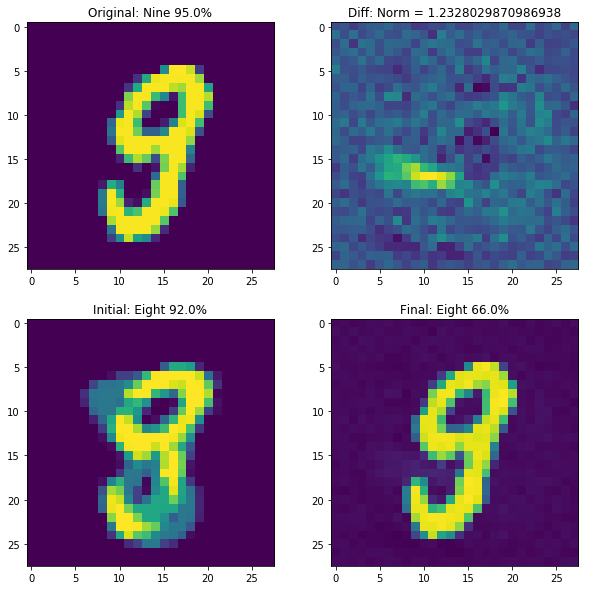

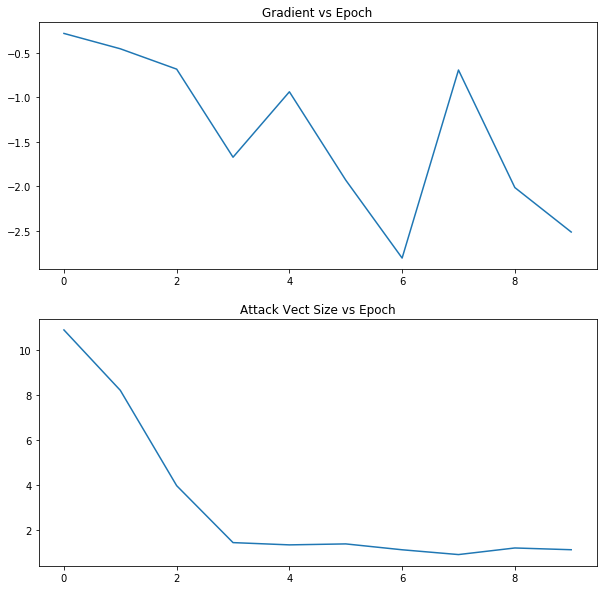

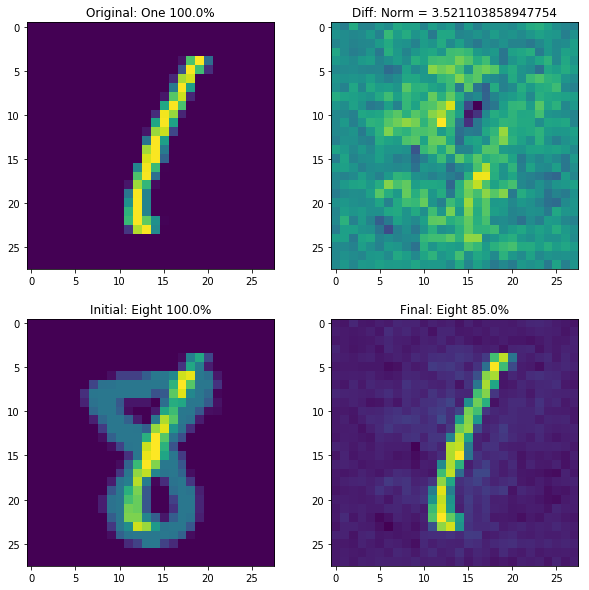

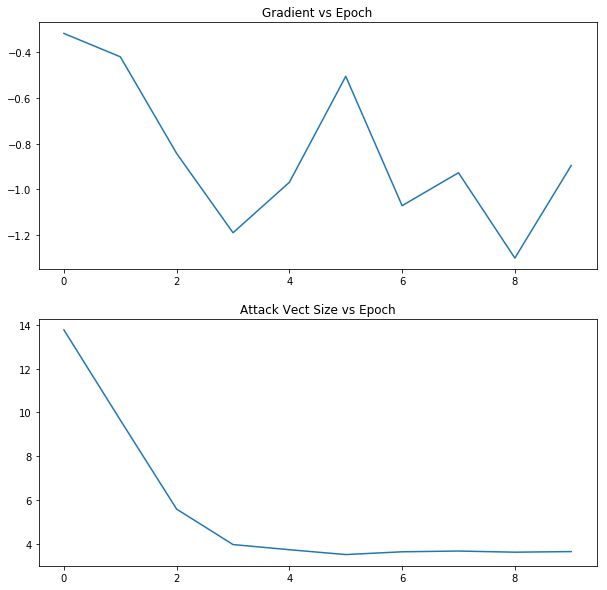

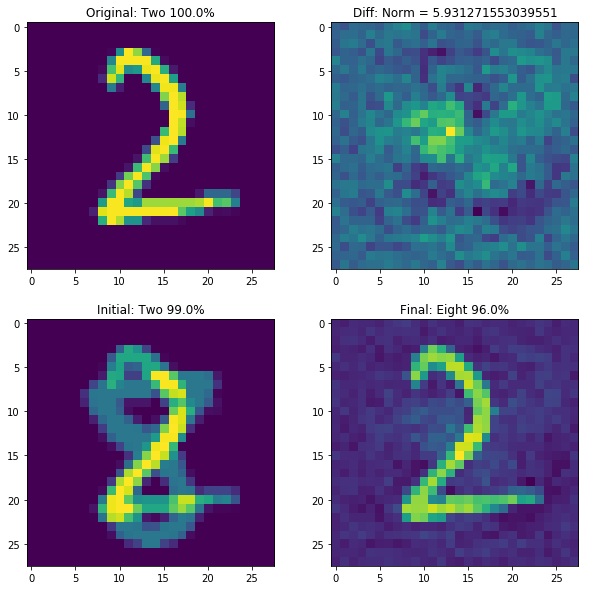

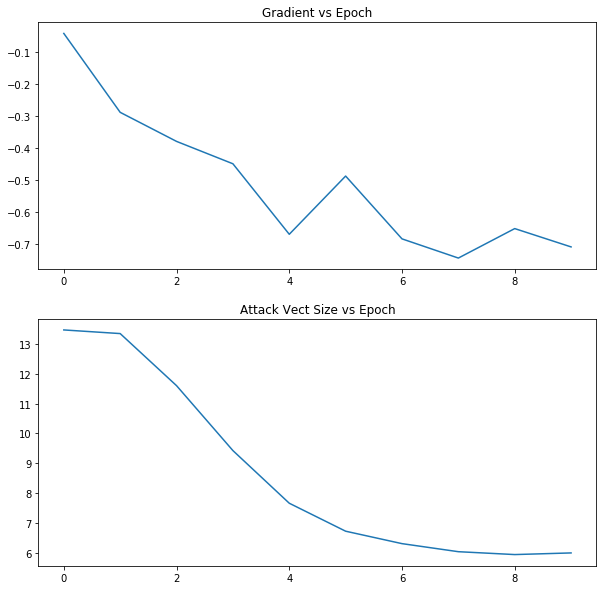

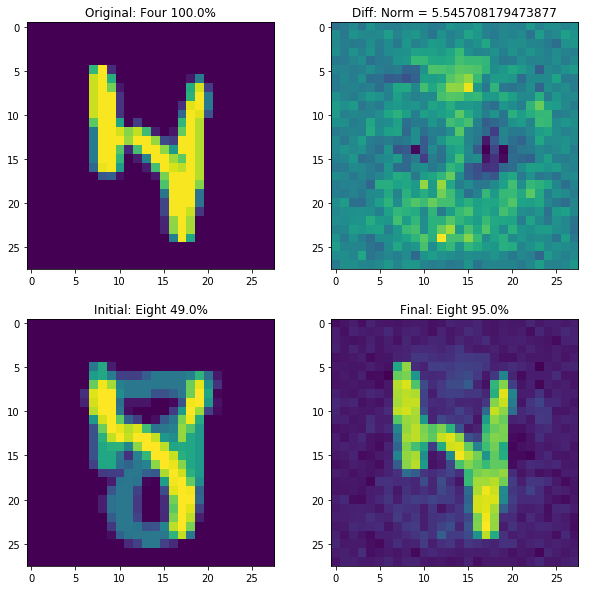

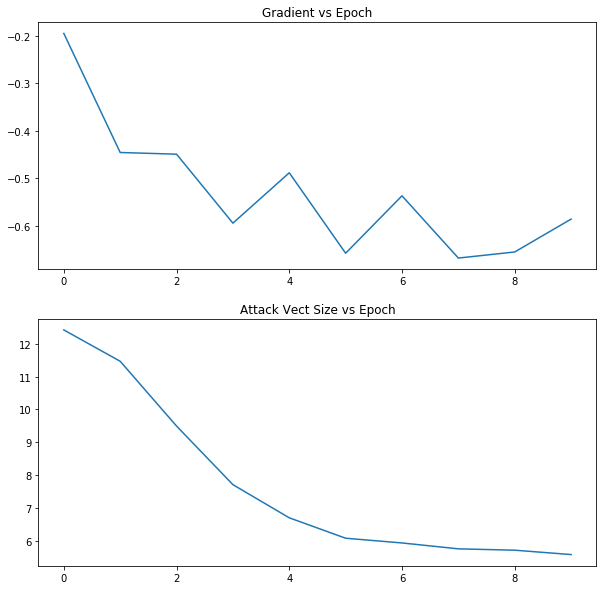

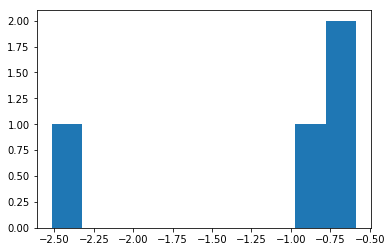

In [6]:
def trainAdversary(model, source_img, source_label, display=False):
    
    _, fgsm_init_attack = train_fgsm(model, source_img, source_label, 1)
    N = model.to(device) # initialize sigmoid layer
    a = torch.autograd.Variable(source_img.to(device), requires_grad=False)
    y = torch.autograd.Variable(source_label.to(device), requires_grad=False)
#     x = torch.autograd.Variable((fgsm_init_attack).to(device), requires_grad=True)
    x = torch.autograd.Variable(0.4*(first_source - source_img).to(device), requires_grad=True)
#     x = torch.autograd.Variable(torch.rand(source_img.shape).to(device)*0.01, requires_grad=True)
#     x = torch.autograd.Variable(DFAttack(source_img, source_label), requires_grad=True)
    x_init = x.clone().to(device)
    if display:
        print("Initial Loss:", N(a))
        print("Init Adv:", N(a + x))
        print(a.shape, y.shape)
    loss_fn = criterion

    lr = 0.001
    num_epochs = 3500
    optimizer = optim.Adam([x], lr=lr)
    A_NL_training = []
    x_norm_training = []
    dist_scaling = 1
    
    for epoch in range(num_epochs):

        t1 = time.time()
        N.zero_grad()
        optimizer.zero_grad()

        loss_adv = loss_fn(N(a + x), y)
        loss_source = loss_fn(N(a), y)

        loss_diff = torch.abs(loss_adv - loss_source) / (torch.norm(x, p=2)**dist_scaling)
#         loss_diff = torch.log(torch.abs(loss_adv - loss_source)) - torch.log(dist_scaling*torch.norm(x, p=2))
#         loss_diff = torch.abs(loss_adv - loss_source)
        grads = grad(loss_diff, x, create_graph=True)
        A_NL = -1*torch.norm(grads[0])

        grads = A_NL.backward()

        if epoch % (num_epochs/10) == 0:

            A_NL_training.append(A_NL.item())
            x_norm_training.append(torch.norm(x).item())
            if display:
                if len(A_NL_training) >= 2:
                    print("EPOCH DIFF:", A_NL_training[-1] - A_NL_training[-2])
                print("Finding Adverserial Vector: " + str(100*(epoch // 50)*(50/num_epochs))+"%")
                print(loss_adv.item())
                print("A_NL VAL:", A_NL.item())
                print("TIME TAKEN:", time.time() - t1)
                print()
        optimizer.step()
        
#         if A_NL.item() == 0.0:
#             print("BAD START")
#             x = torch.autograd.Variable((torch.rand(1, 1, 28, 28)*0.5).to(device), requires_grad=True)
        
    return x, a, x_init, A_NL_training, x_norm_training

def drawPlot(x, a, x_init, N, A_NL_training, x_norm_training, source_label, label_names=None):
    
    result_original = torch.nn.functional.softmax(N(a)[0], dim=0)
    predict_vect_original, predict_label_original = torch.max(result_original, 0)
    predict_vect_original = round(predict_vect_original.item(), 2)

    result = torch.nn.functional.softmax(N(x+a)[0], dim=0)
    predict_vect, predict_label = torch.max(result, 0)
    predict_vect = round(predict_vect.item(), 2)

    result_init = torch.nn.functional.softmax(N(x_init + a)[0], dim=0)
    predict_vect_init, predict_label_init = torch.max(result_init, 0)
    predict_vect_init = round(predict_vect_init.item(), 2)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    if label_names is not None:
        source_name = label_names[source_label.item()]
        predict_name = label_names[predict_label.item()]
        init_predict_name = label_names[predict_label_init.item()]
    else:
        source_name = str(source_label.item())
        predict_name = str(predict_label.item())
        init_predict_name = str(predict_label_init.item())     
        
    ax[0,0].imshow((a)[0, 0].data)
    ax[0,0].set_title("Original: " + source_name+" "+str(predict_vect_original*100)+"%")

    ax[0,1].imshow((x)[0, 0].data)
    ax[0,1].set_title("Diff: Norm = " + str(torch.norm(x).item()))

    ax[1,1].imshow((x + a)[0, 0].data)
    ax[1,1].set_title("Final: " + predict_name +" "+str(predict_vect*100)+"%")

    ax[1,0].imshow((x_init + a)[0, 0].data)
    ax[1,0].set_title("Initial: " + init_predict_name +" "+str(predict_vect_init*100)+"%")
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    ax[0].plot(A_NL_training)
    ax[0].set_title("Gradient vs Epoch")
    ax[1].plot(x_norm_training)
    ax[1].set_title("Attack Vect Size vs Epoch")

final_AGG_vals = []
source_img, source_label = (None, None)
# first_source, first_label = getImageIndex(3, model, test_loader2)
first_source, first_label = getImageByLabel(8, model, test_loader2)
for index in range(4):
    index += 15
#     index = 10
    start_time = time.time()
    source_img, source_label = getImageIndex(index, model, test_loader2)
    x, a, x_init, A_NL_training, x_norm_training = trainAdversary(model, source_img, source_label, display=False)
    finish_time = time.time()
    print("TOTAL ATTACK TIME:", finish_time - start_time)
    drawPlot(x, a, x_init, model, A_NL_training, x_norm_training, source_label, label_names=mnist_class_names)
    final_AGG_vals.append(A_NL_training[-1])

fig, ax = plt.subplots()
ax.hist(final_AGG_vals)

(1, 28, 28) 9 2.8214867
9 9
TOTAL ATTACK TIME: 1.6842617988586426
(1, 28, 28) 1 2.8214867
1 1
TOTAL ATTACK TIME: 2.4165563583374023
(1, 28, 28) 2 2.8214867
2 2
TOTAL ATTACK TIME: 2.168091297149658
(1, 28, 28) 4 2.8214867
4 4
TOTAL ATTACK TIME: 1.910149097442627


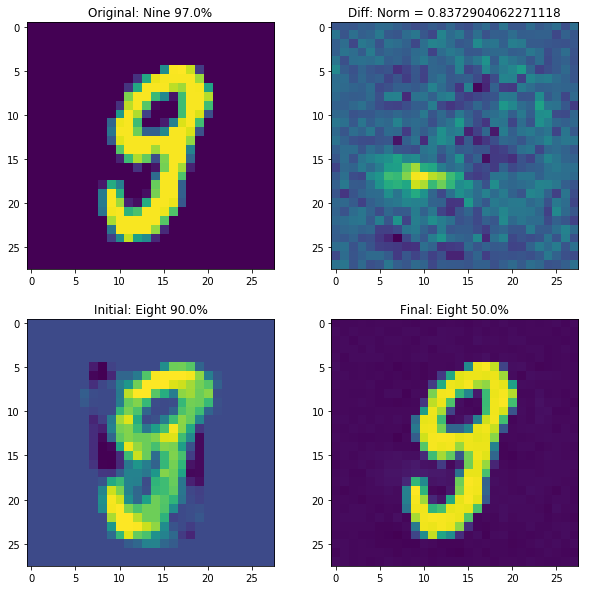

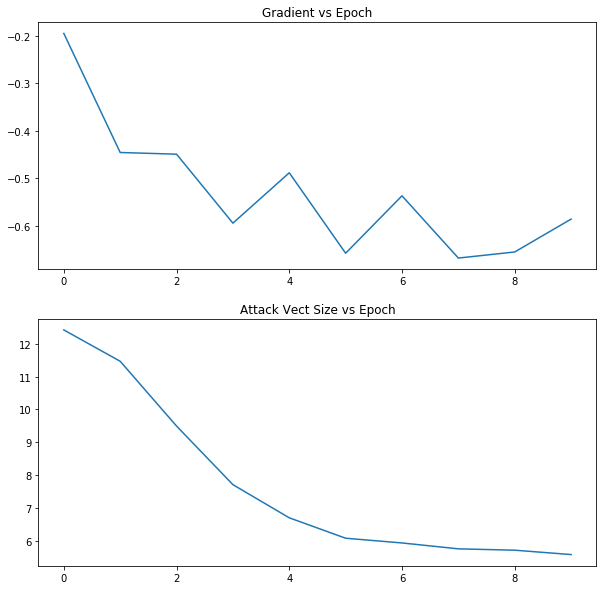

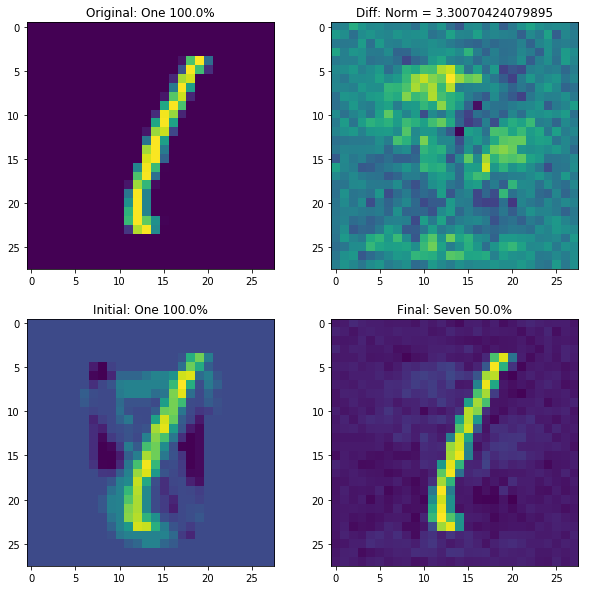

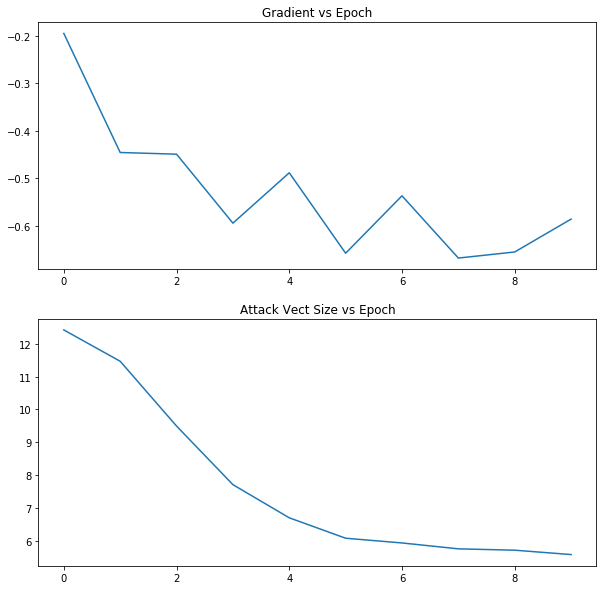

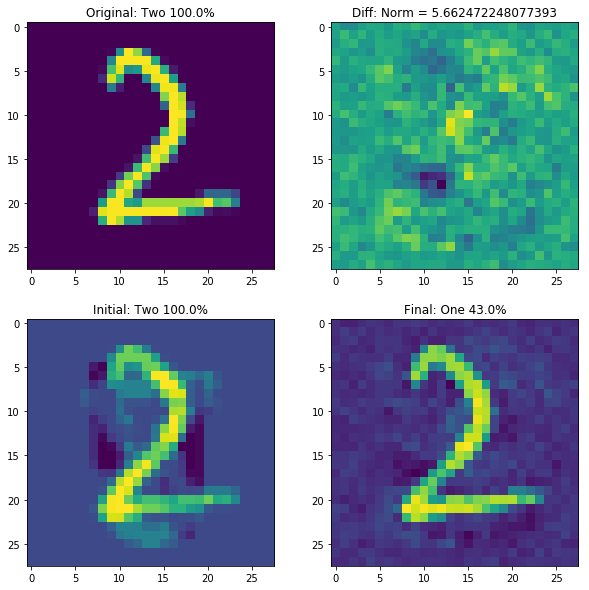

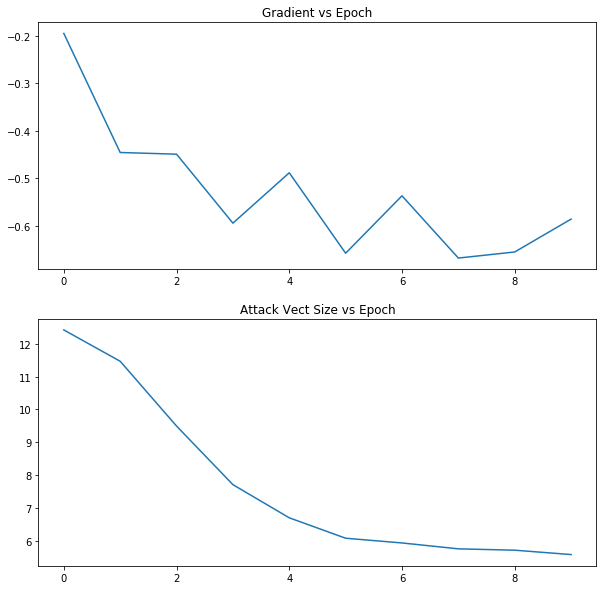

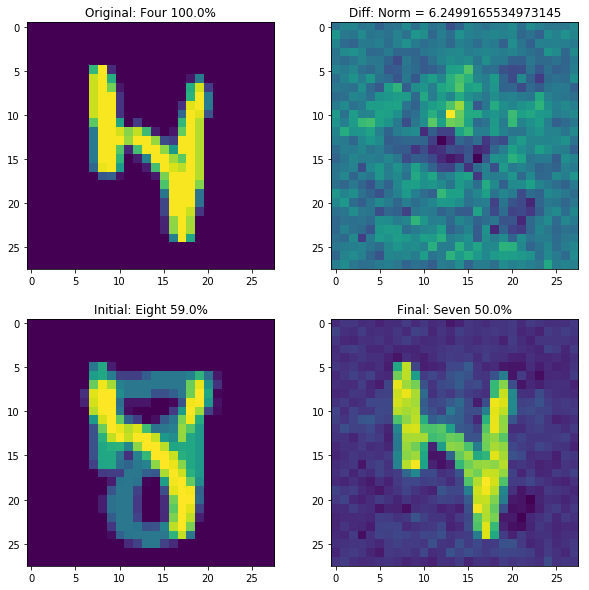

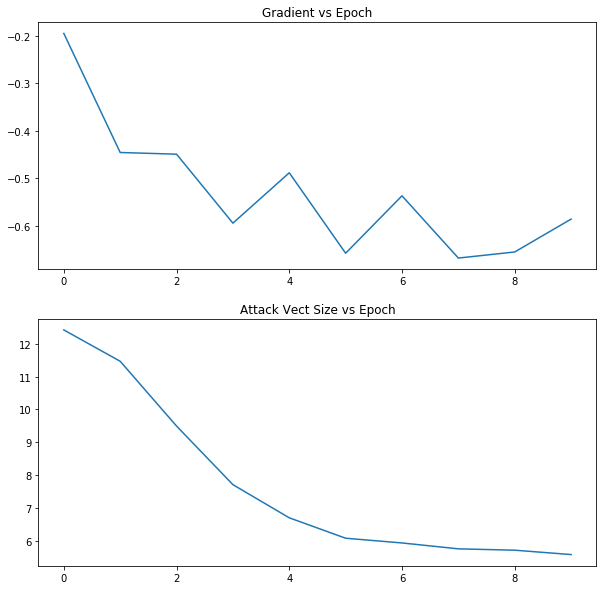

In [7]:
from foolbox.criteria import TargetClassProbability
import foolbox
model.eval()
fmodel = foolbox.models.PyTorchModel(model, bounds=(-4, 4), num_classes=10)
attack_criterion = foolbox.criteria.TargetClass(1)

def DFAttack(source_img, source_label):
    image = source_img.cpu().numpy().reshape(1, 28, 28)
    label = source_label.cpu().numpy()[0]
    print(image.shape, label, image.max())

    attack = foolbox.attacks.DeepFoolAttack(fmodel)

    label_predict = np.argmax(fmodel.predictions(image))
    print(label_predict, label)

    adversarial = attack(image, label=label_predict)
    adversarial_tensor = torch.Tensor(adversarial).cuda()
    return adversarial_tensor - source_img

def BaseAttack(source_img, source_label, attack_model):
    image = source_img.cpu().numpy().reshape(1, 28, 28)
    label = source_label.cpu().numpy()[0]
    print(image.shape, label, image.max())

    attack = attack_model(fmodel, threshold=0.0000001)

    label_predict = np.argmax(fmodel.predictions(image))
    print(label_predict, label)

    adversarial = attack(image, label=label_predict)
    adversarial_tensor = torch.Tensor(adversarial).cuda()
    return adversarial_tensor - source_img

for index in range(4):
    index += 15
#     index = 10
    start_time = time.time()
    source_img, source_label = getImageIndex(index, model, test_loader2)
    adversarial_tensor = BaseAttack(source_img, source_label, foolbox.attacks.CarliniWagnerL2Attack)
#     adversarial_tensor = BaseAttack(source_img, source_label, foolbox.attacks.BoundaryAttack)

    
    finish_time = time.time()
    print("TOTAL ATTACK TIME:", finish_time - start_time)
    drawPlot(adversarial_tensor, source_img, x_init, model, A_NL_training, x_norm_training, source_label, label_names=mnist_class_names)

